In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()

## Varying the Exposure

In [4]:
savefig = False
picformat = 'svg'

bias = 0.0
bias_assumed = 0.1
resolution = 0.
print(bias)


0.0


In [5]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

bias_rnds = infos[:N_max,0]  
resolution_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2]  
indices = pars[:N_max,2:4]  
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]


fluxpoints = []
for f in bias_rnds:
    try:
        print(f'6_fluxpoints_{f:.6}')
        ff = FluxPoints.read(f'data/fluxpoints/6_fluxpoints_{f:.6}.fits') 
        fluxpoints.append(ff)
        
    except:
        pass
    

print(len(fluxpoints), len(bias_rnds))    
N = len(fluxpoints)

151
6_fluxpoints_0.0179084
6_fluxpoints_0.0573949
6_fluxpoints_-0.181378
6_fluxpoints_0.16951
6_fluxpoints_0.217019
6_fluxpoints_0.00204324
6_fluxpoints_-0.0456382
6_fluxpoints_-0.086982
6_fluxpoints_0.0676714
6_fluxpoints_0.0453627
6_fluxpoints_-0.0306966
6_fluxpoints_0.0353091
6_fluxpoints_-0.0931141
6_fluxpoints_0.151051
6_fluxpoints_0.0257077
6_fluxpoints_0.11269
6_fluxpoints_-0.163275
6_fluxpoints_0.0300108
6_fluxpoints_-0.126844
6_fluxpoints_-0.0471087
6_fluxpoints_-0.0590599
6_fluxpoints_-0.084222
6_fluxpoints_-0.0707413
6_fluxpoints_0.0484122
6_fluxpoints_-0.0653464
6_fluxpoints_0.0780895
6_fluxpoints_0.00696475
6_fluxpoints_0.170462
6_fluxpoints_-0.161292
6_fluxpoints_0.0176783
6_fluxpoints_0.0311387
6_fluxpoints_0.119427
6_fluxpoints_-0.000211314
6_fluxpoints_0.021822
6_fluxpoints_0.056579
6_fluxpoints_0.163098
6_fluxpoints_-0.0395289
6_fluxpoints_0.0249557
6_fluxpoints_0.0826189
6_fluxpoints_0.102442
6_fluxpoints_-0.0739081
6_fluxpoints_-0.00136271
6_fluxpoints_0.0197457
6_f

In [6]:

def create_dataset(b, s, bias_assumed):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

dataset, dataset_N , _ = create_dataset(bias, resolution, bias_assumed)

compute edisp
0.0
compute edisp
0.0
compute edisp
0.0


In [7]:
path = f'data/2_model_{bias}_sigma_0.0.yml'
dataset = Dataset_load.load_dataset_N(dataset, path)     

path = f'data/2_model_nui_{bias}_sigma_0.0.yml'
dataset_N = Dataset_load.load_dataset_N(dataset_N, path)     

In [8]:
mask = dataset.mask.data[:,60,60]
ebins = dataset.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

/tmp/ipykernel_16973/4029403509.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
/tmp/ipykernel_16973/4029403509.py:23: RuntimeWarning: divide by zero encountered in true_divide
  np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
/tmp/ipykernel_16973/4029403509.py:23: RuntimeWarning: invalid value encountered in true_divide
  np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
/tmp/ipykernel_16973/4029403509.py:22: RuntimeWarning: invalid value encountered in multiply
  ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *


(-0.24374334930737723, 0.24374334930737723)

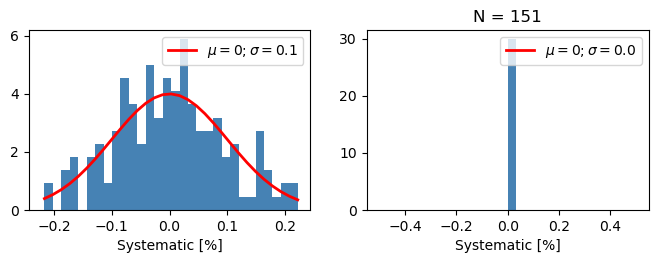

In [9]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(bias_rnds, nbins, density=True, color = 'steelblue')
sigma =bias_assumed
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(resolution_rnds, nbins, density=True, color = 'steelblue')
sigma =resolution
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)



## Compute Asimov Fluxpoints



In [10]:
fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits")
fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits")


In [11]:
energy_edges = dataset_asimov.geoms['geom'].axes[0].edges

In [12]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

In [13]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred'
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'

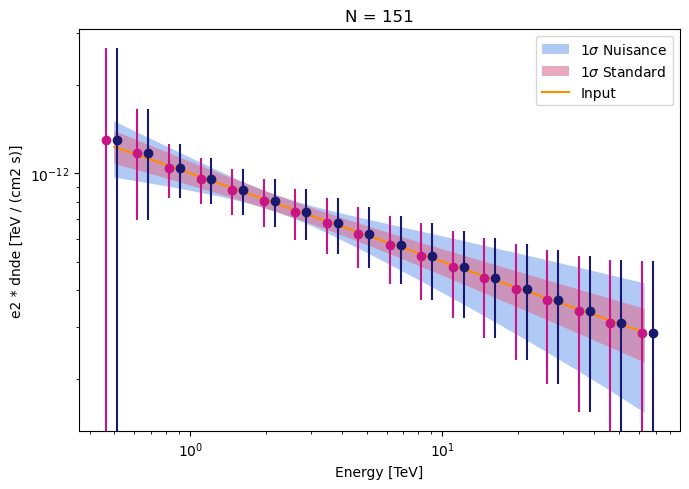

In [14]:
fig, axs = plt.subplots(1,1, figsize = (7,5))
dataset_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = color_nui_e, alpha = 0.5)    
    
dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = color_standard_e, alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = color_input, )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 0.95)
axs.errorbar(e_, f_, yerr = ferr_, color = color_standard, fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.05)
axs.errorbar(e_, f_, yerr = ferr_, color = color_nui, fmt='o')  


axs.legend()
axs.set_title(f"N = {N}")
plt.tight_layout()


In [15]:
'''mask2 = fluxpoints[0].ts.data[:,0,0].data > 4
mask2

fluxpoints[0].ts.data[:,0,0].mask = mask2'''

'mask2 = fluxpoints[0].ts.data[:,0,0].data > 4\nmask2\n\nfluxpoints[0].ts.data[:,0,0].mask = mask2'

In [16]:

e2dnde = []

for f in fluxpoints:
    mask2 = f.ts.data[:,0,0].data > 4
    e2dnde.append(f.e2dnde.data[:,0,0])
e2dnde = np.array(e2dnde)   



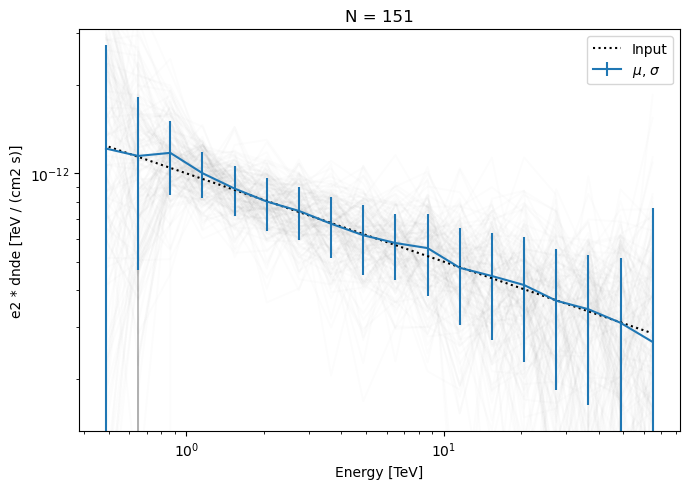

In [17]:
fig, axs1 = plt.subplots(1,1,figsize = (7,5) )
for f,e  in zip(fluxpoints,e2dnde):
    axs1.plot(f.energy_ref* 1.0, e    , color = 'black', alpha = 0.01)
    
axs1.errorbar(f.energy_ref, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
              label = "$\mu$, $\sigma$"
            )

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs1,
                                label = "Input", color = "black", )
ylim = axs.get_ylim()
axs1.set_ylim(ylim[0], ylim[1])
axs1.loglog()
axs1.set_title(f"N = {N}")
axs1.legend()
plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7d_fluxpoints_rnd_{shift}_{N}." + picformat)


In [18]:
def fraction_within_e(lower_lim, upper_lim, data):
    withine = []
    for ie in range(len(lower_lim)):
        xs = []
        for f in data:
            value = f[ie]   
            lowerlim = (np.all(value >= lower_lim[ie]))
            upperlim = (np.all(value <= upper_lim[ie]))
            x = lowerlim & upperlim
            xs.append(x)
        withine.append(np.count_nonzero(xs) / len(data))
    withine  = np.array(withine)
    return withine[withine>0] 

In [19]:
e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.05)
within_e = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.05)
within_eN = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)
within_eN


array([0.67549669, 0.56291391, 0.59602649, 0.62251656, 0.66887417,
       0.62913907, 0.65562914, 0.64900662, 0.62913907, 0.73509934,
       0.62913907, 0.65562914, 0.64238411, 0.64238411, 0.64900662,
       0.68874172, 0.67549669, 0.62913907])

In [20]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)
p = compute_precision(N)

In [21]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred'
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'

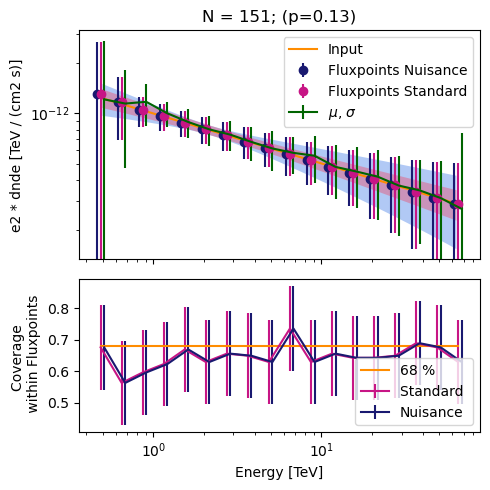

In [22]:
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))

dataset_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = color_nui_e, alpha = 0.5)    
    
dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = color_standard_e, alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = color_input, )

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 0.95)
axs.errorbar(e_, f_, yerr = ferr_, color = color_nui, fmt='o', label = "Fluxpoints Nuisance")  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.0)
axs.errorbar(e_, f_, yerr = ferr_, color = color_standard, fmt='o', label = "Fluxpoints Standard")  



axs.errorbar(f.energy_ref* 1.05, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
             color = color_rnd,
                 label = "$\mu$, $\sigma$")


ax2.errorbar(ebins, within_e, yerr=p,color = color_standard, label = f"Standard ")
ax2.errorbar(ebins*1.05, within_eN,yerr=p, color = color_nui, label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), '-', color = color_input, label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend()
axs.set_title(f"N = {N}; (p={p:.2})")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage \n within Fluxpoints')

axs.set_xlabel('')
axs.legend()

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7d_fluxpoints_coverage_{shift}_{N}." + picformat)
